# Case Técnico BIX: Consultoria de dados para uma empresa de transportes de caminhão.

## Planejamento da Solução

### Entrada



#### Entendimento de Negócio

**Qual é o problema de negócio?**

* Uma empresa terceirizada de transporte de caminhões deseja diminuir os gastos de manutenção dos sistemas de ar de sua frota de veículos. Visto que foi observado que esse valor vem crescendo ao longo dos últimos anos mesmo mantendo o tamanho de sua frota constante. Para resolver esse problema, podemos fazer a seguinte análise:

    1. Realizar a classificação dos caminhões baseado em suas características representadas pela tabela fornecida pelo setor de manutenção de modo a identificar quais desses caminhões possuem defeitos no sistema de ar e assim poder prevenir gastos adicionais.
    2. Dataset dos dados de caminhões


### Saída

* Qual o formato de entrega da solução ? O que o time de negócio irá ver como saída.

    - Documento no formado docx ou pdf, direcionado ao time de negócio com informações pertinentes ao processo de desenvolvimento do modelo que classifica se um caminhão tem um problema em seu sistema de ar.
    - Relatório com os valores da diminuição de gastos gerada pela implementação desse modelo de classificação e apresentação dos principais fatores que podem explicar o comportamento de falha no sistema de ar nos caminhões.
    - Documento em formato pdf com as respostas referentes as perguntas do desafio.




### Metodologia
- CRISP-DM, metodologia ágil para desenvolvimento de projetos de ciência de dados ( método cíclico ).
- Abordagem de classificação.

### Ferramentas Utilizadas
Python 3.10.6, Jupyter-Lab, Git, Github

## Implementações Realizadas na Sprint

### Ciclo 2

* Padronização dos Dados usando Standart Scaling
* Testar outros modelos de Classificação
* Implementação de Cross_Validation 
* Definição das métricas de perfomance do modelo




# 0.0 Imports

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn import model_selection as ms


from sklearn.metrics import recall_score, precision_score,f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold


from lightgbm                import LGBMClassifier
# from xgboost import XGBClassifier

from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import GaussianNB
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost                 import XGBClassifier 

from sklearn.metrics import roc_auc_score

# from sklearn.metrics import plot_confusion_matrix

# from sklearn.metrics import roc_auc_score, plot_precision_recall_curve, plot_roc_curve # AUC ROC
from sklearn.metrics import average_precision_score # AUC PRC

# 0.1 Auxiliar Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container {width:100% !important;} </style>') )
    pd.options.display.max_columns=None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr',False)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    sns.set()
    
jupyter_settings()

def feature_importance(model,x_train_n,y_train_n):
    
    # Model Training
    model.fit(x_train_n,y_train_n)
    
    # Importance
    importances = model.feature_importances_

    # Std
    std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)

    # Indice
    indices = np.argsort(importances)[::-1]

    # Print Feature Ranking
    print('Feature Ranking')
    df = pd.DataFrame()

    for i, j in zip(x_train_n,model.feature_importances_):
        aux = pd.DataFrame({'feature': i,'importance':j}, index=[0])
        df = pd.concat([df,aux],axis=0)

    print(df.sort_values('importance',ascending=False))

    value = x_train_n.shape[1]

    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(value),importances[indices] ,color='r',yerr=std[indices],align='center')
    plt.xticks(range(value),indices)
    plt.xlim([-1,value])
    plt.show()
    
def classification_metrics(model_name,y,yhat):
    
    recall = recall_score(y, yhat)
    f1score = f1_score(y,yhat)

    
    return pd.DataFrame({'Model Name': model_name,
                          'Recall': recall,
                          'F1_Score': f1score},index=[0])


def cross_validation(model, x_train, y_train, k, Verbose=True):
    
    kfold = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
    
    recall_list = []
    f1_score_list = []
    roc_auc_list = []
    i = 1
    
    for train_cv, val_cv in kfold.split(x_train,y_train):
        
        if Verbose == True:
            print(f'Fold Number {i}/{k}')
            
        else:
            pass
        
        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        model.fit(x_train_fold,y_train_fold)
        
        yhat_model = model.predict(x_val_fold)
        yhat_model_proba = model.predict_proba(x_val_fold)
        
        
        
        # Metrics 
        
        # Recall
        recall = recall_score(y_val_fold, yhat_model)
        recall_list.append(recall)
        
        # F1 Score
        f1score = f1_score(y_val_fold,yhat_model)
        f1_score_list.append(f1score)
        
        # ROC AUC
        roc_auc = roc_auc_score(y_val_fold,yhat_model_proba[:,1])
        roc_auc_list.append(roc_auc)
        
        i+=1
        
    
    df = pd.DataFrame( {'Model Name': type(model).__name__,
                        'Recall': np.mean(recall_list),
                        'ROC AUC': np.mean(roc_auc_list),
                        'F1 Score': np.mean(f1_score_list)},index=[0])
    
    return df
        
    

In [3]:
# plot_clf_metrics(rf,'RF Testing', x_validation,y_validation)

# 0.2 Loading Data

In [4]:
df_raw_prev = pd.read_csv('../data/air_system_previous_years.csv')
df_raw_present =  pd.read_csv('../data/air_system_present_year.csv')

In [5]:
df_raw_prev.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,120960

# 1.0 Data Description

In [6]:
df1 = df_raw_prev.copy()

## 1.1 Data Columns

In [7]:
df1.columns

Index(['class', 'aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000',
       'ag_000', 'ag_001', 'ag_002',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=171)

## 1.2 Data Dimension 


In [8]:
print('Formato do dataset: {} linhas e {} colunas'.format(df1.shape[0], df1.shape[1]))

Formato do dataset: 60000 linhas e 171 colunas


## 1.3 Data Types

In [9]:
# df1.dtypes

Nessa etapa podemos observar que praticamente todas variáveis estão como tipo de objeto, portanto precisamos transformas elas do tipo numero visto que só possuí numeros como valores.

## 1.4 Change Types /  Fill NA / Check Duplicated

In [10]:
# ec_00 ck_000 ci_000 bt_000

In [11]:
df1 = df1.replace('na','0')
df1 = df1.astype({col: float for col in df1.columns[1:]})

In [12]:
df1.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698.00,0.00,2130706438.00,280.00,0.00,0.00,0.00,0.00,0.00,0.00,37250.00,1432864.00,3664156.00,1007684.00,25896.00,0.00,2551696.00,0.00,0.00,0.00,0.00,0.00,4933296.00,3655166.00,1766008.00,1132040.00,0.00,0.00,0.00,0.00,1012.00,268.00,0.00,0.00,0.00,0.00,0.00,469014.00,4239660.00,703300.00,755876.00,0.00,5374.00,2108.00,4114.00,12348.00,615248.00,5526276.00,2378.00,4.00,0.00,0.00,2328746.00,1022304.00,415432.00,287230.00,310246.00,681504.00,1118814.00,3574.00,0.00,0.00,6700214.00,0.00,10.00,108.00,50.00,2551696.00,97518.00,947550.00,799478.00,330760.00,353400.00,299160.00,305200.00,283680.00,0.00,0.00,0.00,178540.00,76698.08,6700214.00,6700214.00,6599892.00,43566.00,68656.00,54064.00,638360.00,6167850.00,1209600.00,246244.00,2.00,96.00,0.00,5245752.00,0.00,916567.68,6.00,1924.00,0.00,0.00,0.00,118196.00,1309472.00,3247182.00,1381362.00,98822.00,11208.00,1608.00,220.00,240.00,6700214.00,0.00,10476.00,1226.00,267998.00,521832.00,428776.00,4015854.00,895240.00,26330.00,118.00,0.00,532.00,734.00,4122704.00,51288.00,0.00,532572.00,0.00,18.00,5330690.00,4732.00,1126.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,62282.00,85908.00,32790.00,0.00,0.00,202710.00,37928.00,14745580.00,1876644.00,0.00,0.00,0.00,0.00,2801180.00,2445.80,2712.00,965866.00,1706908.00,1240520.00,493384.00,721044.00,469792.00,339156.00,157956.00,73224.00,0.00,0.00,0.00
1,neg,33058.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18254.00,653294.00,1720800.00,516724.00,31642.00,0.00,1393352.00,0.00,68.00,0.00,0.00,0.00,2560898.00,2127150.00,1084598.00,338544.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,71510.00,772720.00,1996924.00,99560.00,0.00,7336.00,7808.00,13776.00,13086.00,1010074.00,1873902.00,14726.00,6.00,0.00,0.00,1378576.00,447166.00,199512.00,154298.00,137280.00,138668.00,165908.00,229652.00,87082.00,4708.00,3646660.00,86.00,454.00,364.00,350.00,1393352.00,49028.00,688314.00,392208.00,341420.00,359780.00,366560.00,0.00,0.00,0.00,0.00,0.00,6700.00,33057.51,3646660.00,3646660.00,3582034.00,17733.00,260120.00,115626.00,6900.00,2942850.00,1209600.00,0.00,0.00,0.00,0.00,2291079.36,0.00,643536.96,0.00,0.00,0.00,0.00,38.00,98644.00,1179502.00,1286736.00,336388.00,36294.00,5192.00,56.00,0.00,0.00,3646660.00,0.00,6160.00,796.00,164860.00,350066.00,272956.00,1837600.00,301242.00,9148.00,22.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3312.00,522.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33736.00,36946.00,5936.00,0.00,0.00,103330.00,16254.00,4510080.00,868538.00,0.00,0.00,0.00,0.00,3477820.00,2211.76,2334.00,664504.00,824154.00,421400.00,178064.00,293306.00,245416.00,133654.00,81140.00,97576.00,1500.00,0.00,0.00
2,neg,41040.00,0.00,228.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,1648.00,370592.00,1883374.00,292936.00,12016.00,0.00,1234132.00,0.00,0.00,0.00,0.00,0.00,23719

In [13]:
duplicated = df1[df1.duplicated()]
duplicated

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000


In [14]:
# df1.isna().sum()

## 1.7 Descriptive Statistics

In [15]:
num_attributes = df1.select_dtypes(include=['float64'])

In [16]:
num_attributes.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,76698.00,0.00,2130706438.00,280.00,0.00,0.00,0.00,0.00,0.00,0.00,37250.00,1432864.00,3664156.00,1007684.00,25896.00,0.00,2551696.00,0.00,0.00,0.00,0.00,0.00,4933296.00,3655166.00,1766008.00,1132040.00,0.00,0.00,0.00,0.00,1012.00,268.00,0.00,0.00,0.00,0.00,0.00,469014.00,4239660.00,703300.00,755876.00,0.00,5374.00,2108.00,4114.00,12348.00,615248.00,5526276.00,2378.00,4.00,0.00,0.00,2328746.00,1022304.00,415432.00,287230.00,310246.00,681504.00,1118814.00,3574.00,0.00,0.00,6700214.00,0.00,10.00,108.00,50.00,2551696.00,97518.00,947550.00,799478.00,330760.00,353400.00,299160.00,305200.00,283680.00,0.00,0.00,0.00,178540.00,76698.08,6700214.00,6700214.00,6599892.00,43566.00,68656.00,54064.00,638360.00,6167850.00,1209600.00,246244.00,2.00,96.00,0.00,5245752.00,0.00,916567.68,6.00,1924.00,0.00,0.00,0.00,118196.00,1309472.00,3247182.00,1381362.00,98822.00,11208.00,1608.00,220.00,240.00,6700214.00,0.00,10476.00,1226.00,267998.00,521832.00,428776.00,4015854.00,895240.00,26330.00,118.00,0.00,532.00,734.00,4122704.00,51288.00,0.00,532572.00,0.00,18.00,5330690.00,4732.00,1126.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,62282.00,85908.00,32790.00,0.00,0.00,202710.00,37928.00,14745580.00,1876644.00,0.00,0.00,0.00,0.00,2801180.00,2445.80,2712.00,965866.00,1706908.00,1240520.00,493384.00,721044.00,469792.00,339156.00,157956.00,73224.00,0.00,0.00,0.00
1,33058.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18254.00,653294.00,1720800.00,516724.00,31642.00,0.00,1393352.00,0.00,68.00,0.00,0.00,0.00,2560898.00,2127150.00,1084598.00,338544.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,71510.00,772720.00,1996924.00,99560.00,0.00,7336.00,7808.00,13776.00,13086.00,1010074.00,1873902.00,14726.00,6.00,0.00,0.00,1378576.00,447166.00,199512.00,154298.00,137280.00,138668.00,165908.00,229652.00,87082.00,4708.00,3646660.00,86.00,454.00,364.00,350.00,1393352.00,49028.00,688314.00,392208.00,341420.00,359780.00,366560.00,0.00,0.00,0.00,0.00,0.00,6700.00,33057.51,3646660.00,3646660.00,3582034.00,17733.00,260120.00,115626.00,6900.00,2942850.00,1209600.00,0.00,0.00,0.00,0.00,2291079.36,0.00,643536.96,0.00,0.00,0.00,0.00,38.00,98644.00,1179502.00,1286736.00,336388.00,36294.00,5192.00,56.00,0.00,0.00,3646660.00,0.00,6160.00,796.00,164860.00,350066.00,272956.00,1837600.00,301242.00,9148.00,22.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3312.00,522.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,33736.00,36946.00,5936.00,0.00,0.00,103330.00,16254.00,4510080.00,868538.00,0.00,0.00,0.00,0.00,3477820.00,2211.76,2334.00,664504.00,824154.00,421400.00,178064.00,293306.00,245416.00,133654.00,81140.00,97576.00,1500.00,0.00,0.00
2,41040.00,0.00,228.00,100.00,0.00,0.00,0.00,0.00,0.00,0.00,1648.00,370592.00,1883374.00,292936.00,12016.00,0.00,1234132.00,0.00,0.00,0.00,0.00,0.00,2371990.00,2173634.00,3

In [17]:
num_attributes.describe()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00,60000.00
mean,59336.50,0.16,336225803.58,143407.08,6.54,10.55,219.16,964.81,8509.77,87600.54,432208.44,1095978.52,1639277.96,493725.86,35172.10,5057.55,1790474.42,8922.44,1131.69,907.66,58497.78,92303.43,3424003.95,2972966.35,993415.05,438061.53,0.47,125.41,5018.87,228.16,1071.25,358.72,12075.08,10076.16,10852.26,7144.98,10447.84,110726.81,1066489.40,1528742.57,1039367.91,1149.62,7761.82,4371.55,7975.88,86265.18,1460380.03,2111700.91,100754.74,17183.48,654.39,41.60,1383602.61,883864.92,408360.09,270865.01,202526.34,186774.66,208213.61,183657.02,35471.38,35356.60,4477520.78,543.66,879.88,1315.38,71.76,1790070.07,57323.09,487375.74,505081.85,172772.38,175260.95,136204.74,123586.67,116886.52,112667.32,109560.38,108234.38,79388.19,59251.13,4463323.22,4463323.79,3888993.19,21855.27,97333.52,36325.16,400729.93,3597106.75,1195971.84,61660.43,143107.04,68.85,0.00,3461593.27,102262.51,710318.57,288.40,286.62,2309.92,21700.15,159206.84,525392.53,1268146.68,1325703.59,405863.13,63687.46,19006.64,7730.92,143328.04,544.51,4463323.69,8.44,5418.76,779.63,236147.91,351410.71,439275.13,2210462.10,539688.79,14606.72,209.39,770.51,576.70,941.52,1484937.99,270616.01,211.08,14915.62,5.69,10.33,1694285.77,2993.64,358.12,2537.03,5235.21,4392.64,34761.30,37.27,1737.01,26635.18,7393.82,333

In [18]:
# Central Tendency - Media, Mediana 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion std, min, max, range,skew,kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [19]:
# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [20]:
m.head()

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,aa_000,0.00,2746564.00,2746564.00,59336.50,30776.00,145428.84,6.12,48.30
1,ab_000,0.00,204.00,204.00,0.16,0.00,1.69,57.04,5119.17
2,ac_000,0.00,2130706796.00,2130706796.00,336225803.58,120.00,776756070.81,1.88,1.52
3,ad_000,0.00,8584297742.00,8584297742.00,143407.08,42.00,35044955.49,244.95,60000.00
4,ae_000,0.00,21050.00,21050.00,6.54,0.00,158.15,92.53,11228.41


# 2.0 Feature Engineering

In [21]:
df_raw_prev.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,703300,755876,0,5374,2108,4114,12348,615248,5526276,2378,4,0,0,2328746,1022304,415432,287230,310246,681504,1118814,3574,0,0,6700214,0,10,108,50,2551696,97518,947550,799478,330760,353400,299160,305200,283680,na,na,na,178540,76698.08,6700214,6700214,6599892,43566,68656,54064,638360,6167850,1209600,246244,2,96,0,5245752,0,916567.68,6,1924,0,0,0,118196,1309472,3247182,1381362,98822,11208,1608,220,240,6700214,na,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.8,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,0,71510,772720,1996924,99560,0,7336,7808,13776,13086,1010074,1873902,14726,6,0,0,1378576,447166,199512,154298,137280,138668,165908,229652,87082,4708,3646660,86,454,364,350,1393352,49028,688314,392208,341420,359780,366560,na,na,na,na,na,6700,33057.51,3646660,3646660,3582034,17733.0,260120,115626,6900,2942850,1209600,0,na,na,na,2291079.36,0,643536.96,0,0,0,0,38,98644,1179502,1286736,336388,36294,5192,56,na,0,3646660,na,6160,796,164860,350066,272956,1837600,301242,9148,22,0,na,na,na,na,na,na,na,na,na,3312,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,0,0,870456,239798,1450312,0,1620,1156,1228,34250,1811606,710672,34,0,0,0,790690,672026,332340,254892,189596,135758,103552,81666,46,0,2673338,128,202,576,4,1234132,28804,160176,139730,137160,130640,na,na,na,na,na,na,28000,41040.08,2673338,2673338,2678534,15439.0,7466,22436,248240,2560566,1209600,63328,0,124,0,2322692.16,0,236099.52,0,0,0,0,0,33276,1215280,1102798,196502,10260,2422,28,0,6,2673338,na,3584,500,56362,149726,100326,1744838,488302,16682,246,0,230,292,2180528,29188,22,20346,0,0,2341048,1494,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,0,0,0,2038,5596,0,64,6,6,914,76,2478,2398,1692,0,0,6176,340,304,102,74,406,216,16,0,0,21614,2,12,0,0,2668,184,7632,3090,na,na,na,na,na,na,na,na,10580,12.69,21614,21614,21772,32,50,1994,21400,7710,120960

# 3.0 Variables Filtering

# 4.0 EDA

In [22]:
df4 = df1.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

In [23]:
df4['class'] = df4['class'].apply(lambda x: 1 if x == 'pos' else 0)

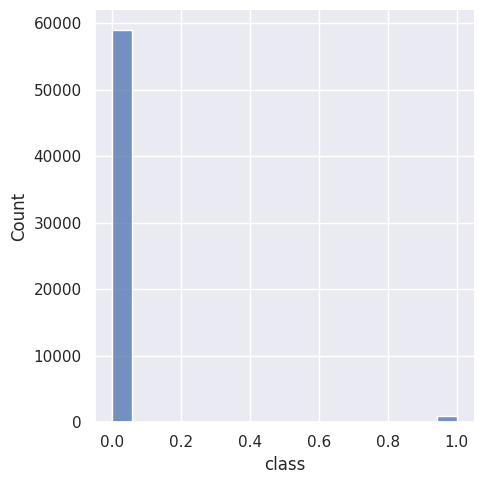

In [24]:
sns.displot(df4['class'],kde=False);

In [25]:
df4['class'].value_counts()

0    59000
1     1000
Name: class, dtype: int64

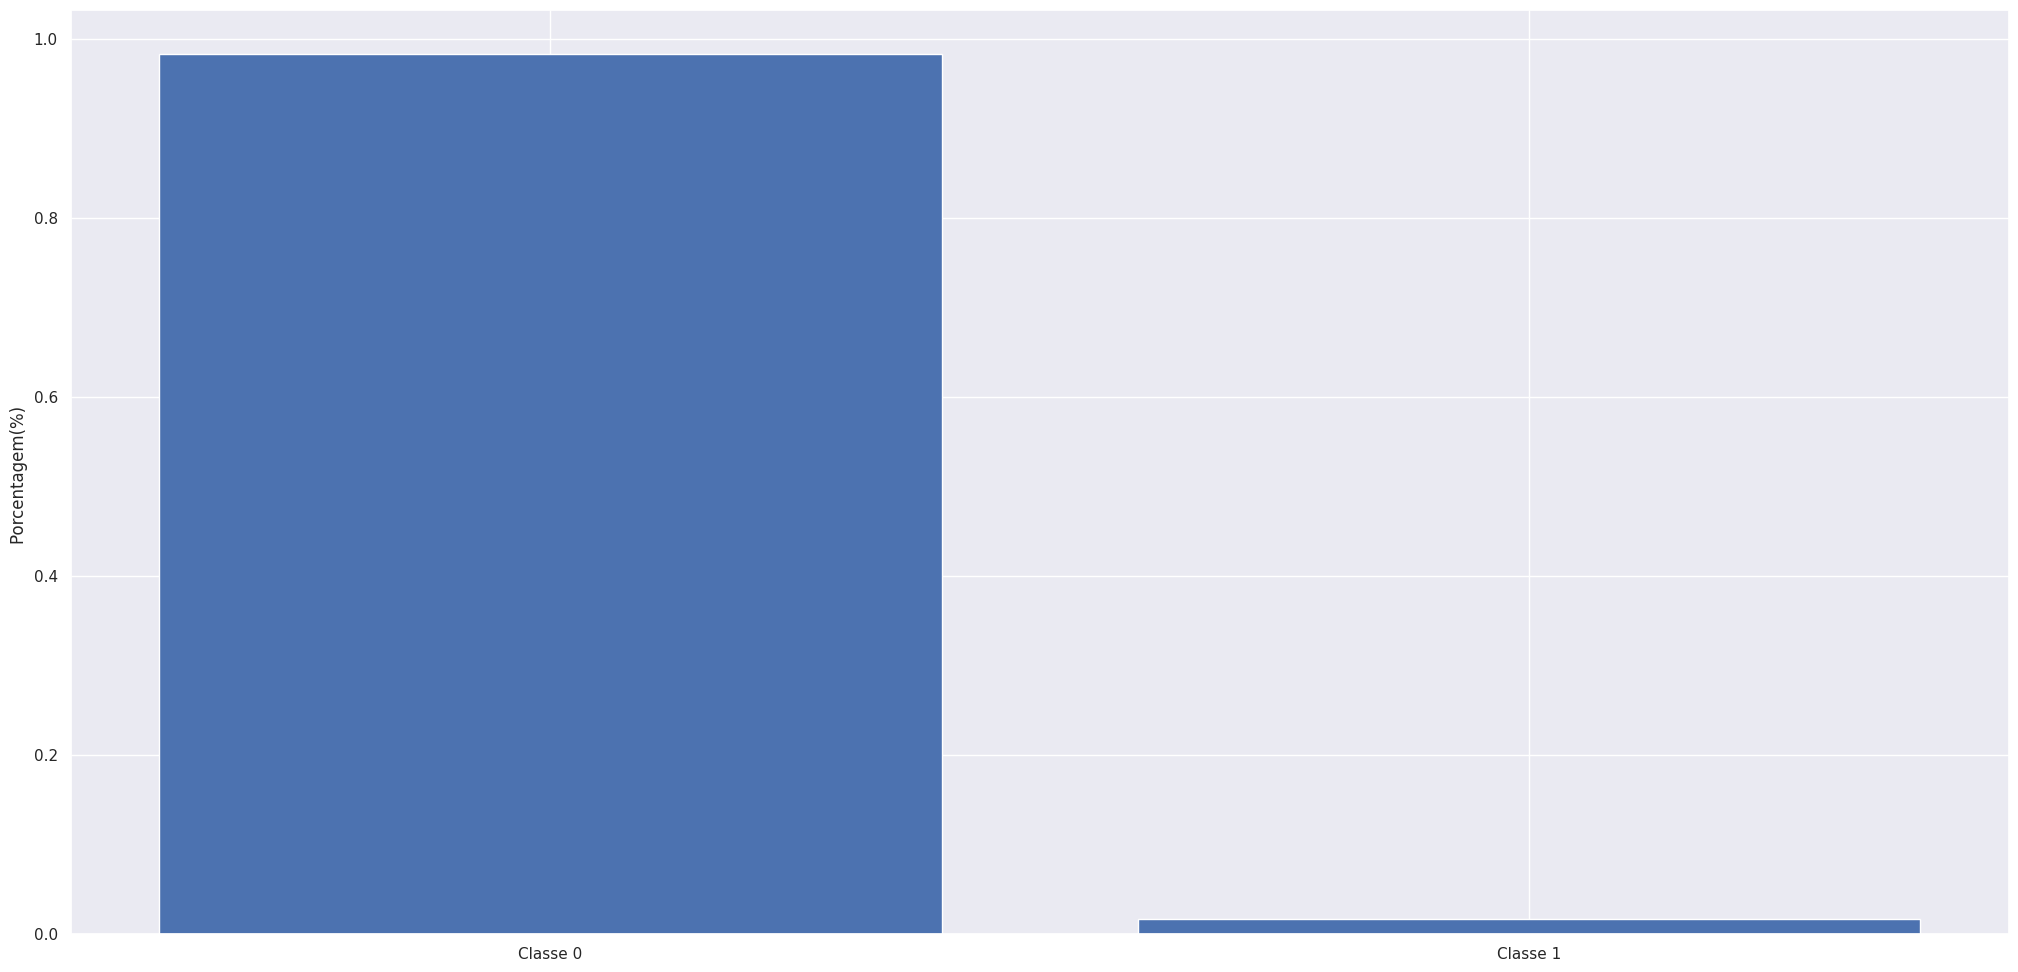

In [27]:
distri = df4['class'].value_counts(normalize=True) 
plt.bar(x=distri.index,height=distri)
plt.xticks([0,1],['Classe 0','Classe 1'])
plt.ylabel('Porcentagem(%) ');


In [28]:
distri

0   0.98
1   0.02
Name: class, dtype: float64

- 59000 caminhões com outros tipos de manutenção. (98%)
- 1000 caminhões com manutenção de sistema de ar. (2%)

--- > Muito desbalanceado, somente cerca de 2% dos dados desses caminhões possuem problema no sistema de ar

## 4.2 Numerical Variables

In [29]:
# num_attributes.hist(bins=25);

# 5.0 Data Preparation

In [36]:
df5 = df4.copy()

In [37]:
X = df4.drop('class',axis=1)
y = df4['class'].copy()

In [38]:
x_train, x_validation, y_train, y_validation = ms.train_test_split(X,y,test_size=0.20,random_state=42)

In [39]:
x_train.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
48572,18.00,0.00,22.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,1916.00,2956.00,0.00,0.00,0.00,606.00,0.00,0.00,0.00,0.00,0.00,6408.00,4912.00,31398.00,492.00,0.00,0.00,0.00,0.00,10.00,22.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,960.00,3922.00,0.00,98.00,58.00,84.00,1010.00,128.00,3504.00,0.00,0.00,0.00,0.00,3344.00,416.00,156.00,94.00,180.00,108.00,444.00,62.00,10.00,68.00,37822.00,0.00,6.00,0.00,0.00,606.00,126.00,29982.00,1396.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31280.00,17.96,37822.00,37822.00,39494.00,23.00,10.00,3732.00,37700.00,4934.00,1209600.00,322.00,2.00,0.00,0.00,2637.12,286.08,995.52,2.00,22.00,0.00,0.00,0.00,1272.00,2714.00,890.00,6.00,0.00,0.00,0.00,0.00,22.00,37822.00,0.00,1030.00,12.00,18.00,16.00,346.00,916.00,2078.00,448.00,18.00,0.00,6.00,28.00,2530.00,104.00,0.00,0.00,0.00,0.00,2854.00,32.00,96.00,0.00,0.00,280.00,1666.00,0.00,0.00,0.00,0.00,176.00,0.00,0.00,0.00,0.00,62.00,18.00,10260.00,1036.00,0.00,20.00,0.00,0.00,0.00,0.76,44.00,2434.00,1962.00,126.00,64.00,104.00,154.00,38.00,0.00,0.00,0.00,0.00,0.00
38696,30.00,0.00,42.00,42.00,0.00,0.00,0.00,0.00,0.00,0.00,50.00,4250.00,3442.00,0.00,0.00,0.00,3058.00,0.00,0.00,0.00,0.00,0.00,7478.00,5016.00,12224.00,1182.00,0.00,0.00,0.00,0.00,108.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,7742.00,0.00,0.00,0.00,52.00,6.00,10.00,20.00,180.00,7432.00,42.00,0.00,0.00,0.00,6030.00,1288.00,274.00,66.00,32.00,18.00,16.00,18.00,0.00,0.00,19714.00,4.00,20.00,6.00,0.00,3058.00,200.00,9554.00,2664.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12100.00,29.51,19714.00,19714.00,25582.00,17.00,0.00,1882.00,19620.00,7742.00,1209600.00,618.00,0.00,2.00,0.00,4595.52,0.00,3117.12,0.00,0.00,0.00,0.00,0.00,3722.00,3834.00,186.00,0.00,0.00,0.00,0.00,6.00,36.00,19714.00,0.00,68.00,10.00,12.00,268.00,506.00,1156.00,4324.00,1350.00,48.00,0.00,72.00,78.00,5032.00,66.00,0.00,28.00,0.00,0.00,5124.00,56.00,40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,0.00,0.00,0.00,0.00,254.00,50.00,520.00,58.00,20522.00,32.00,0.00,0.00,0.00,43.32,28.00,3470.00,3348.00,734.00,82.00,102.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00
13611,14.00,0.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,64.00,3108.00,2666.00,0.00,0.00,0.00,2244.00,0.00,0.00,0.00,0.00,0.00,3840.00,1362.00,11826.00,594.00,0.00,0.00,0.00,0.00,10.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4208.00,1630.00,0.00,54.00,24.00,14.00,32.00,2132.00,3582.00,0.00,0.00,0.00,0.00,4494.00,284.00,302.00,76.00,50.00,40.00,108.00,436.00,48.00,0.00,15694.00,0.00,4.00,4.00,0.00,2244.00,172.00,8964.00,2844.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11600.00,14.89,15694.00,15694.00,18518.00,26.00,270.00,1464.00,15400.00,5838.00,1209600.00,0.00,0.00,0.00,0.00,1862.40,0.00,2946.24,0.00,18.00,0.00,0.00,0.00,1998.00,2698.00,1142.00,0.00,0.00,0.00,0.00,0.00,0.00,15694.00,0.00,1002.00,14.00,22.00,490.00,878.

## 5.2 Rescaling Features

In [40]:
from sklearn import preprocessing as pp

In [41]:
minmax = pp.MinMaxScaler()
sc = pp.StandardScaler()

In [42]:
# df5 = pd.DataFrame(minmax.fit_transform(df5.values), columns=df5.columns, index=df5.index)

x_train_scaler = sc.fit_transform(x_train)
x_val_scaler = sc.transform(x_validation)

# x_train = pd.DataFrame(sc.fit_transform(x_train.values), columns=x_train.columns, index=x_train.index)
# x_validation = pd.DataFrame(sc.fit_transform(x_validation.values), columns=x_validation.columns, index=x_validation.index)

# x_train = pd.DataFrame(minmax.fit_transform(x_train.values), columns=x_train.columns, index=x_train.index)
# x_validation = pd.DataFrame(minmax.fit_transform(x_validation.values), columns=x_validation.columns, index=x_validation.index)

In [46]:
x_train = pd.DataFrame(x_train_scaler)
x_validation = pd.DataFrame(x_val_scaler)

# 6.0 Feature Selection and Space Study

In [ ]:
# x_train_n = df5.copy()
# y_train_n = y_train.values

## 6.1 ExtraTrees 


In [ ]:
# from sklearn.ensemble        import RandomForestClassifier, ExtraTreesClassifier, RandomForestClassifier

In [ ]:
# # Model Definition
# extratree = ExtraTreesClassifier(n_estimators=250,random_state=0,n_jobs=-1)

# # Model Training and Featuring Importance
# feature_importance(extratree,x_train_std,y_train_n)

## 6.2 PCA

In [ ]:
from sklearn import decomposition as d

In [ ]:
x_train_std.shape

In [ ]:
## DADOS DE TREINO
pca = d.PCA(n_components=25)

principal_components_train = pca.fit_transform(x_train_std)
principal_components_validation = pca.fit_transform(x_validation_std)

# plot explained variables
features = range(pca.n_components_)

plt.bar(features,pca.explained_variance_ratio_,color='black')

# pca component
x_train_pca = pd.DataFrame(principal_components_train)
x_validation_pca = pd.DataFrame(principal_components_validation)

In [ ]:
x_train_pca.head()

In [ ]:
x_validation_pca.head()

# 7.0 Machine Learning Model

## 7.1 KNN Base Model 

In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

,Model Name,Recall,F1_Score
0,KNN,0.52,0.63


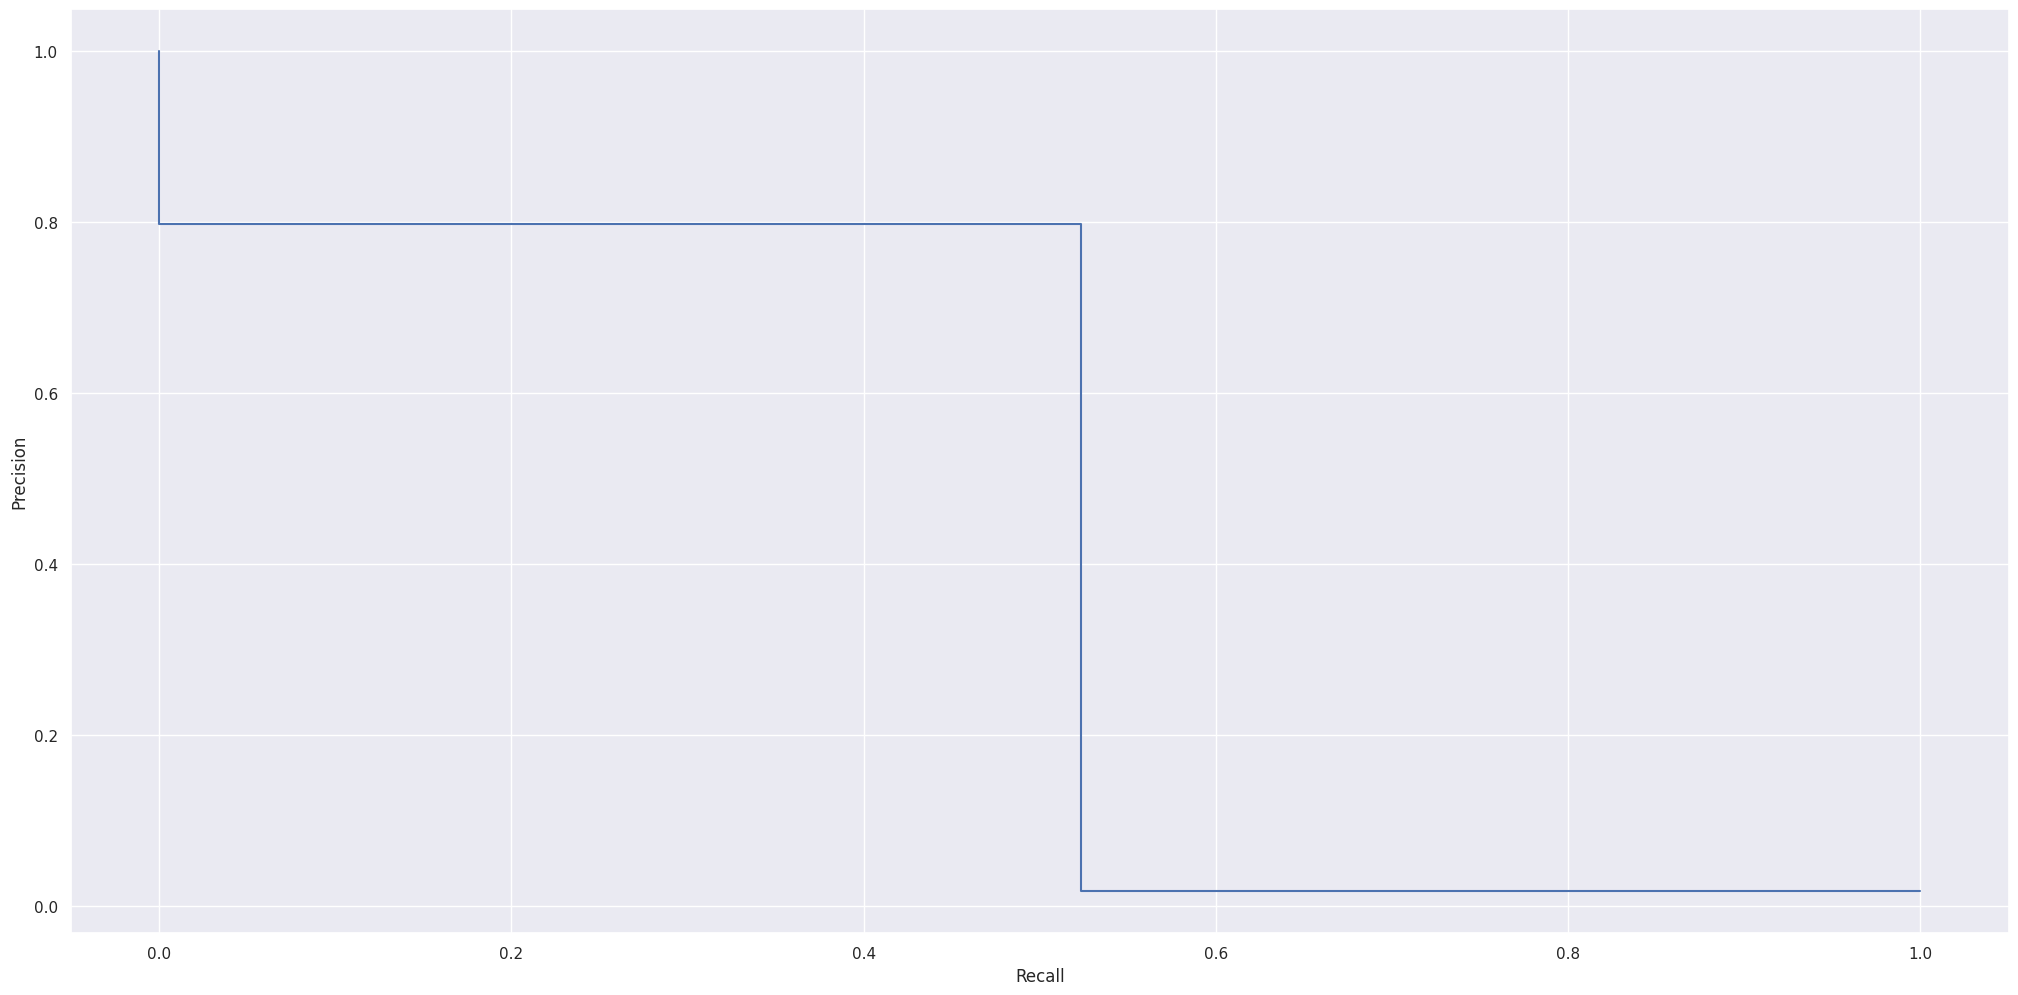

In [49]:
# - O algoritmo de Machine Learning que será utilizado como modelo baseline será o KNN (K-Nearest Neighbors, ou K-vizinhos mais próximos). 
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train,y_train)

yhat_knn = knn.predict(x_validation)

prec, recall, _ = precision_recall_curve(y_validation, yhat_knn, pos_label=knn.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

classification_metrics('KNN', y_validation,yhat_knn)

### 7.1.1  KNN Cross Validation

In [52]:
knn_cv = cross_validation(knn,x_train,y_train,5,Verbose=False)

## 7.2 Logistic Regression 

/home/jordan/Estudismo/case_bix/case_tecnico/venv_truck/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model Name,Recall,F1_Score
0,KNN,0.67,0.72


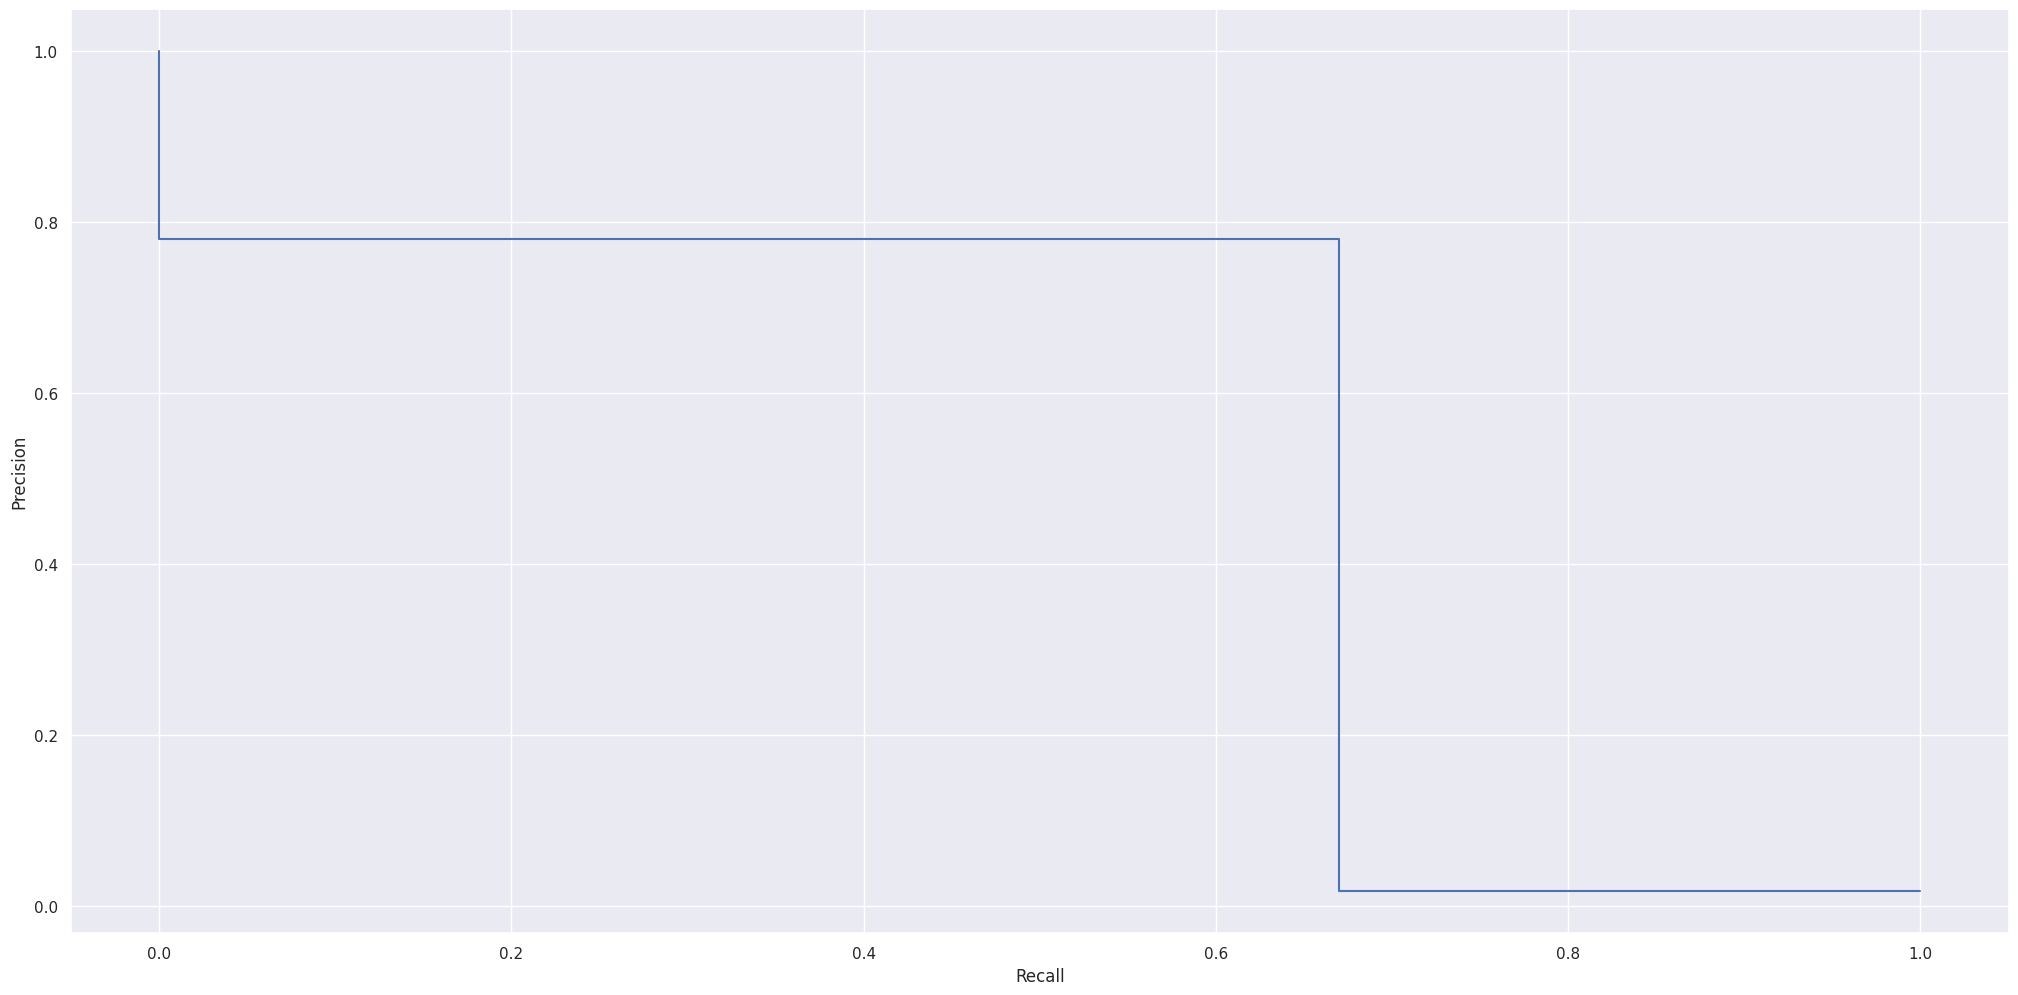

In [53]:
lr = LogisticRegression() 

lr.fit(x_train,y_train)

yhat_lr = lr.predict(x_validation)

prec, recall, _ = precision_recall_curve(y_validation, yhat_lr, pos_label=lr.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

classification_metrics('KNN', y_validation,yhat_lr)

### 7.2.1 Logistic Regression Cross Validation

In [54]:
lr_cv = cross_validation(lr,x_train,y_train,5,Verbose=False)

/home/jordan/Estudismo/case_bix/case_tecnico/venv_truck/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jordan/Estudismo/case_bix/case_tecnico/venv_truck/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

## 7.3 Random Forest Classifier

,Model Name,Recall,F1_Score
0,RandomForest,0.66,0.75


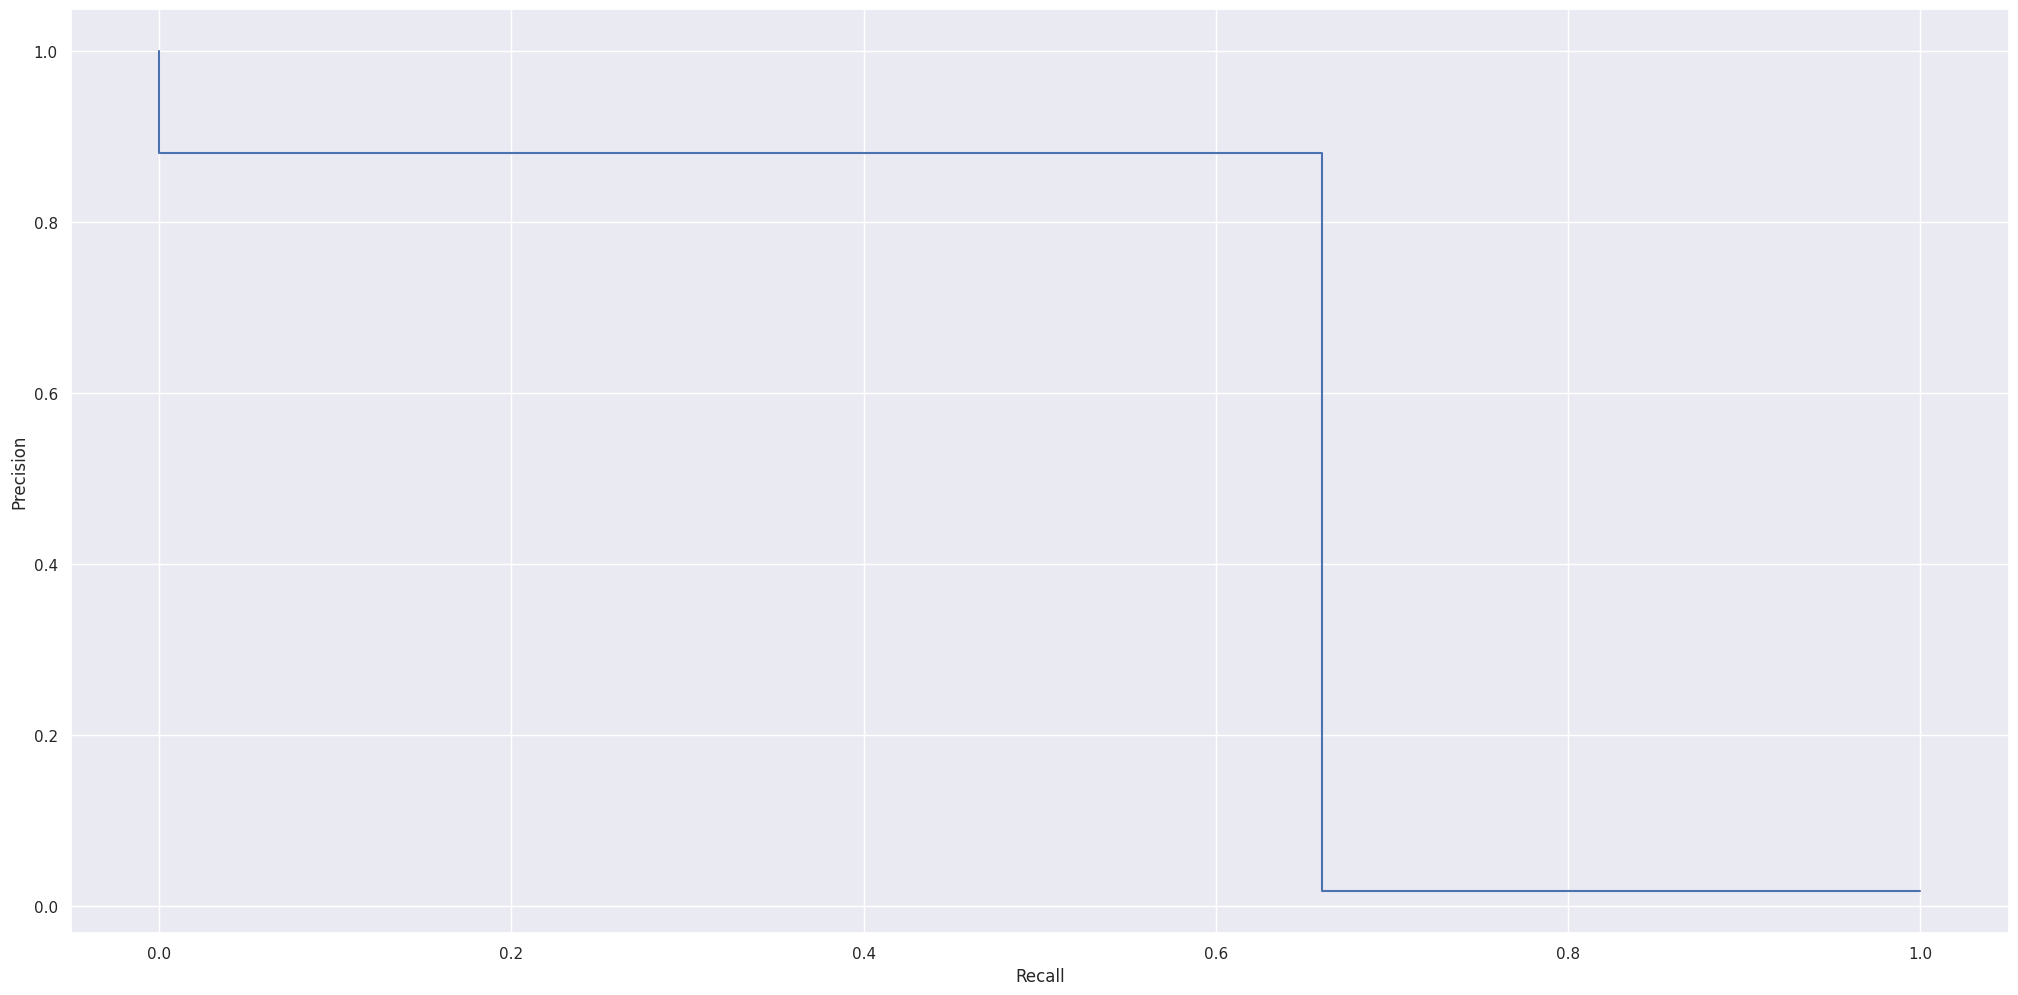

In [55]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(x_train,y_train)

yhat_rf = rf.predict(x_validation)


prec, recall, _ = precision_recall_curve(y_validation, yhat_rf, pos_label=rf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

classification_metrics('RandomForest', y_validation,yhat_rf)


### 7.3.1 Random Forest CV

In [56]:
rf_cv = cross_validation(rf,x_train,y_train,5,Verbose=False)

## 7.4 LGBM Classifier

,Model Name,Recall,F1_Score
0,LGBM,0.72,0.79


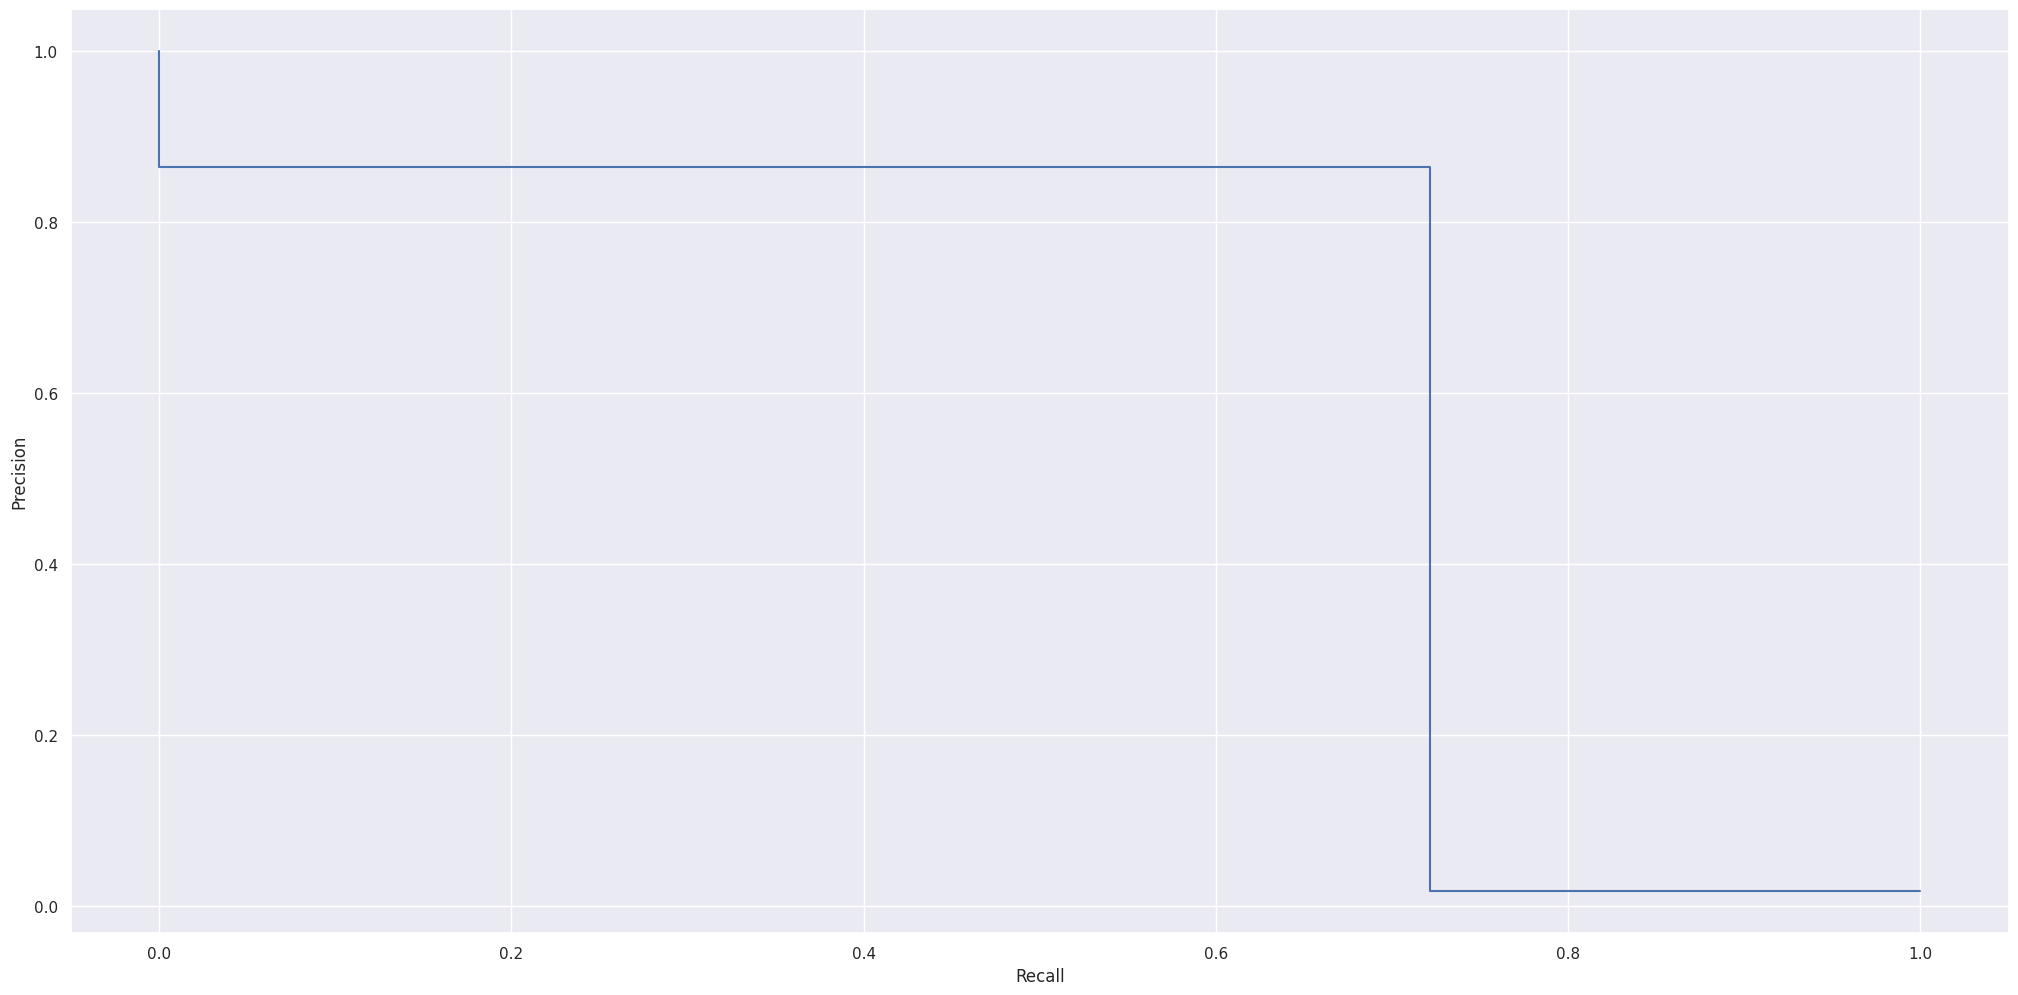

In [57]:
lgbm = LGBMClassifier()

lgbm.fit(x_train,y_train)

yhat_lgbm = lgbm.predict(x_validation)

prec, recall, _ = precision_recall_curve(y_validation, yhat_lgbm, pos_label=lgbm.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

classification_metrics('LGBM', y_validation,yhat_lgbm)

### 7.4.1 LGBM Cross-Validation

In [58]:
lgbm_cv = cross_validation(lgbm,x_train,y_train,5,Verbose=False)

## 7.5 XGBoost Classifier

,Model Name,Recall,F1_Score
0,XGBoost,0.73,0.79


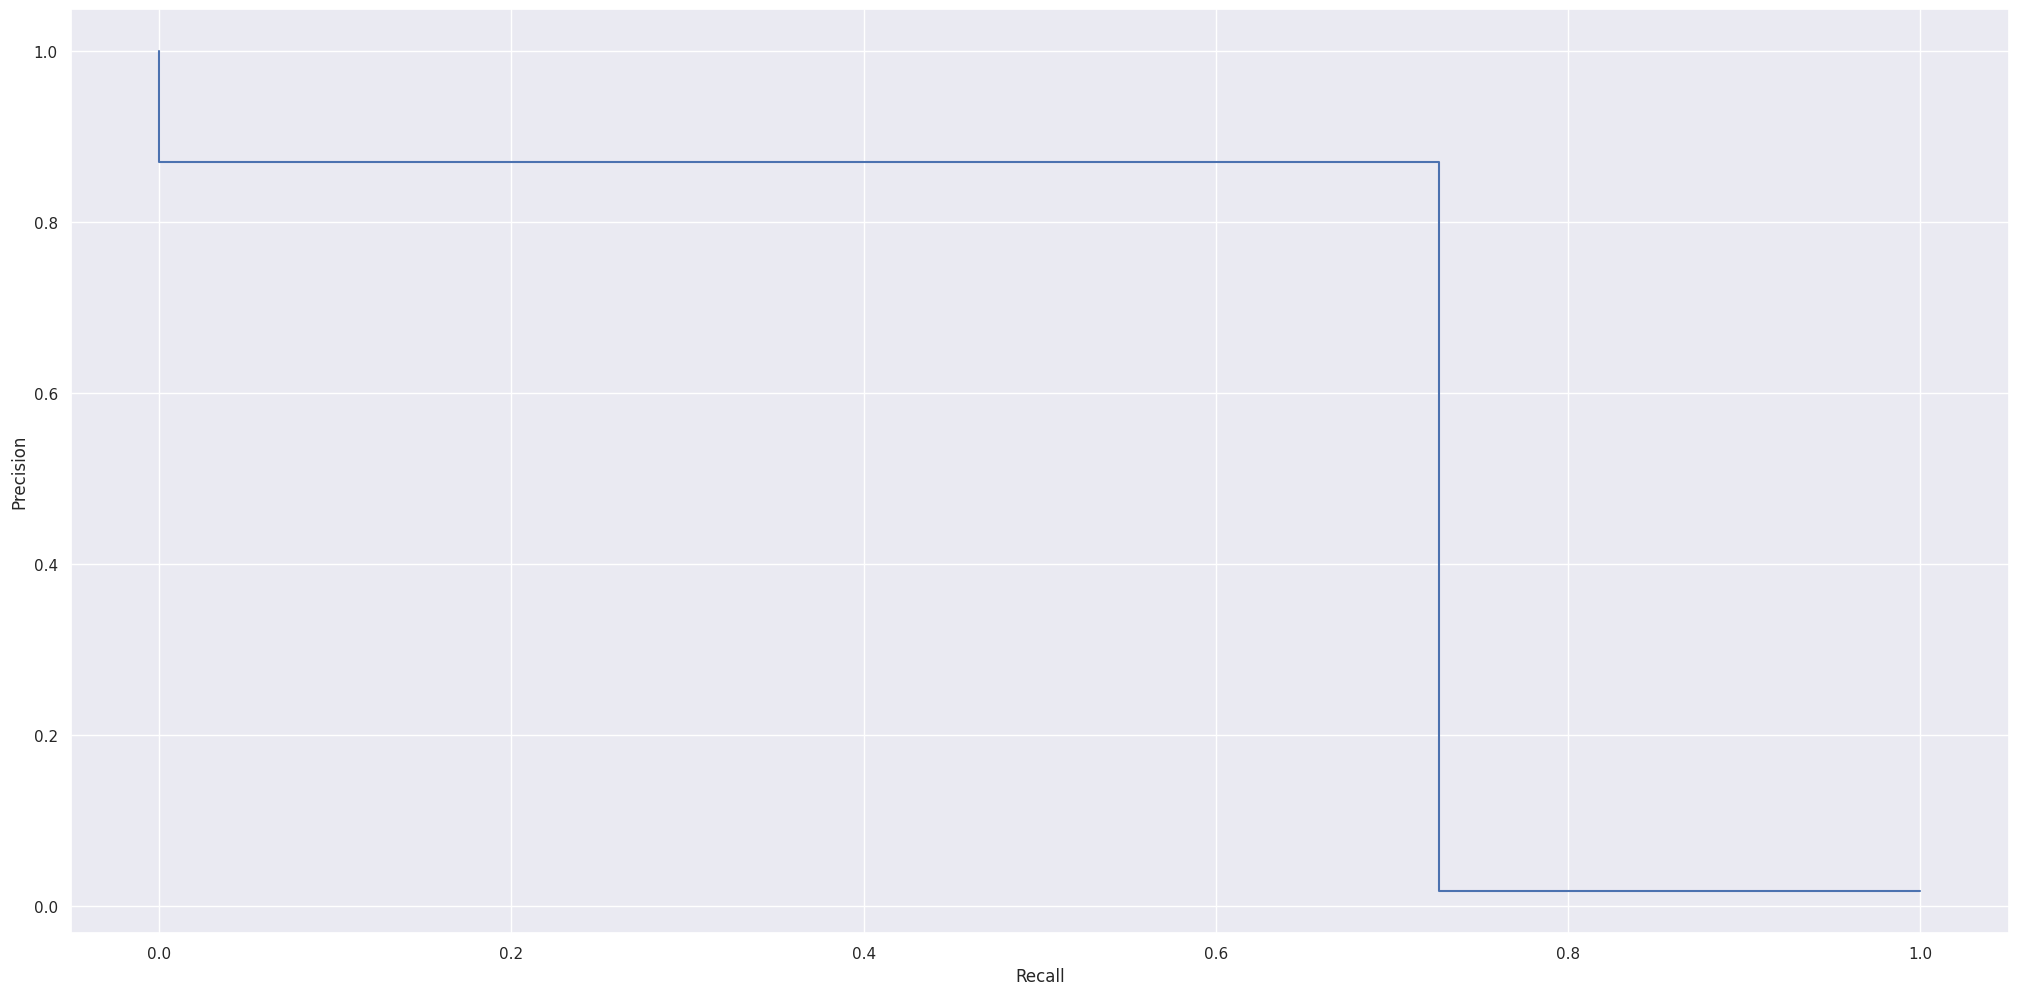

In [59]:
xgboost = XGBClassifier(n_jobs=-1)

xgboost.fit(x_train,y_train)

yhat_xgboost = xgboost.predict(x_validation)


prec, recall, _ = precision_recall_curve(y_validation, yhat_xgboost, pos_label=xgboost.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

classification_metrics('XGBoost', y_validation,yhat_xgboost)

In [60]:
xgb_cv = cross_validation(xgboost,x_train,y_train,5,Verbose=False)

## 7.6 Compare Model Perfomance


### 7.6.1 Real Perfomance - Cross Validation 

In [61]:
model_results_cv = pd.concat([knn_cv,lr_cv,rf_cv,lgbm_cv,xgb_cv]) 
model_results_cv.sort_values('Recall',ascending=False)

,Model Name,Recall,ROC AUC,F1 Score
0,XGBClassifier,0.73,0.99,0.80
0,LGBMClassifier,0.70,0.99,0.78
0,RandomForestClassifier,0.68,0.99,0.78
0,LogisticRegression,0.65,0.97,0.71
0,KNeighborsClassifier,0.51,0.90,0.62


# 8.0 Hyper Parameter Fine Tuning

# 9.0 Final Model - Testing XGBoost

## 9.1 Test Dataset Transformation


In [268]:
df_test = pd.read_csv('../data/air_system_present_year.csv')

In [269]:
df_test['class'].value_counts()

neg    15625
pos      375
Name: class, dtype: int64

In [270]:
df_test = df_test.replace('na','0')
df_test = df_test.astype({col: float for col in df1.columns[1:]})
df_test['class'] = df_test['class'].apply(lambda x: 1 if x == 'pos' else 0)

In [271]:
x_test = df_test.drop(['class'],axis=1)
y_test = df_test['class']

In [272]:
x_test.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,60.00,0.00,20.00,12.00,0.00,0.00,0.00,0.00,0.00,2682.00,4736.00,3862.00,1846.00,0.00,0.00,0.00,3976.00,0.00,0.00,0.00,1520.00,2374.00,11516.00,9480.00,111258.00,470.00,0.00,0.00,0.00,0.00,58.00,26.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,13124.00,2.00,1956.00,434.00,76.00,174.00,190.00,6198.00,1148.00,2948.00,2.00,0.00,8762.00,2566.00,480.00,380.00,196.00,516.00,86.00,66.00,74.00,0.00,124340.00,4.00,6.00,4.00,0.00,3976.00,318.00,107662.00,3458.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,110980.00,59.53,124340.00,124340.00,184970.00,54.00,686.00,12246.00,123880.00,13196.00,1209600.00,598.00,0.00,6.00,0.00,5913.60,0.00,5851.20,6.00,30.00,0.00,2.00,5512.00,4674.00,1388.00,1508.00,38.00,4.00,0.00,0.00,8.00,12.00,124340.00,0.00,1550.00,14.00,36.00,26.00,920.00,430.00,7650.00,2294.00,206.00,0.00,22.00,42.00,5336.00,1276.00,0.00,0.00,0.00,0.00,6598.00,70.00,112.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,340.00,0.00,0.00,1100.00,574.00,232.00,66.00,780.00,882.00,0.00,4.00,0.00,0.00,0.00,465.50,90.00,7502.00,3156.00,1098.00,138.00,412.00,654.00,78.00,88.00,0.00,0.00,0.00,0.00
1,82.00,0.00,68.00,40.00,0.00,0.00,0.00,0.00,0.00,0.00,748.00,12594.00,3636.00,0.00,0.00,0.00,5244.00,0.00,60.00,0.00,0.00,0.00,23174.00,18166.00,23686.00,1270.00,0.00,0.00,0.00,0.00,12.00,82.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,692.00,16286.00,0.00,280.00,44.00,50.00,1274.00,866.00,3362.00,11102.00,0.00,0.00,0.00,12564.00,1756.00,638.00,276.00,172.00,132.00,812.00,308.00,192.00,128.00,46894.00,4.00,2.00,38.00,0.00,5244.00,360.00,20520.00,3134.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23320.00,81.89,46894.00,46894.00,48324.00,68.00,0.00,4486.00,46480.00,17050.00,1209600.00,726.00,2.00,4.00,0.00,7224.96,0.00,7768.32,0.00,42.00,0.00,0.00,4.00,7064.00,6200.00,2452.00,1246.00,12.00,0.00,0.00,14.00,54.00,46894.00,0.00,2202.00,28.00,114.00,350.00,700.00,1708.00,9622.00,2174.00,80.00,0.00,80.00,206.00,7802.00,1466.00,0.00,0.00,0.00,0.00,7918.00,78.00,40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,352.00,0.00,0.00,3996.00,584.00,200.00,62.00,37580.00,3756.00,6368.00,36.00,0.00,0.00,0.00,2.86,102.00,10040.00,3310.00,1068.00,276.00,1620.00,116.00,86.00,462.00,0.00,0.00,0.00,0.00
2,66002.00,2.00,212.00,112.00,0.00,0.00,0.00,0.00,0.00,199486.00,1358536.00,1952422.00,452706.00,25130.00,520.00,0.00,1891670.00,0.00,0.00,0.00,77898.00,110548.00,3605894.00,3291610.00,959756.00,286536.00,0.00,0.00,0.00,0.00,106.00,340.00,0.00,0.00,0.00,0.00,0.00,24286.00,681260.00,2808472.00,474782.00,0.00,22984.00,894.00,1162.00,1304.00,1856.00,388700.00,3424812.00,123828.00,23260.00,0.00,1662580.00,667960.00,387998.00,226078.00,161558.00,148288.00,154908.00,220820.00,147744.00,210866.00,4644422.00,958.00,7848.00,3624.00,0.00,1891670.00,47066.00,692800.00,265492.00,336240.00,194360.00,245240.00,0.00,0.00,0.00,0.00,0.00,175480.00

StandarScaler on the test dataset

In [273]:
x_test = pd.DataFrame(sc.fit_transform(x_test.values), columns=x_test.columns, index=x_test.index)

## 9.2 Dataset Preparation

In [275]:
x_train_final = pd.concat([x_train,x_validation],axis=0)
y_train_final = pd.concat([y_train,y_validation],axis=0)

## 9.3 Final Model

In [278]:
xgboost = XGBClassifier(n_jobs=-1)

xgboost.fit(x_train_final,y_train_final)

yhat_xgboost = xgboost.predict(x_test)




In [280]:
# lgbm_f = classification_metrics('lgbm',y_test,yhat_lgbm)
# rf_f = classification_metrics('rf',y_test,yhat_rf)
xgb_f = classification_metrics('xgb',y_test,yhat_xgboost)
xgb_f

,Model Name,Recall,F1_Score
0,xgb,0.71,0.82


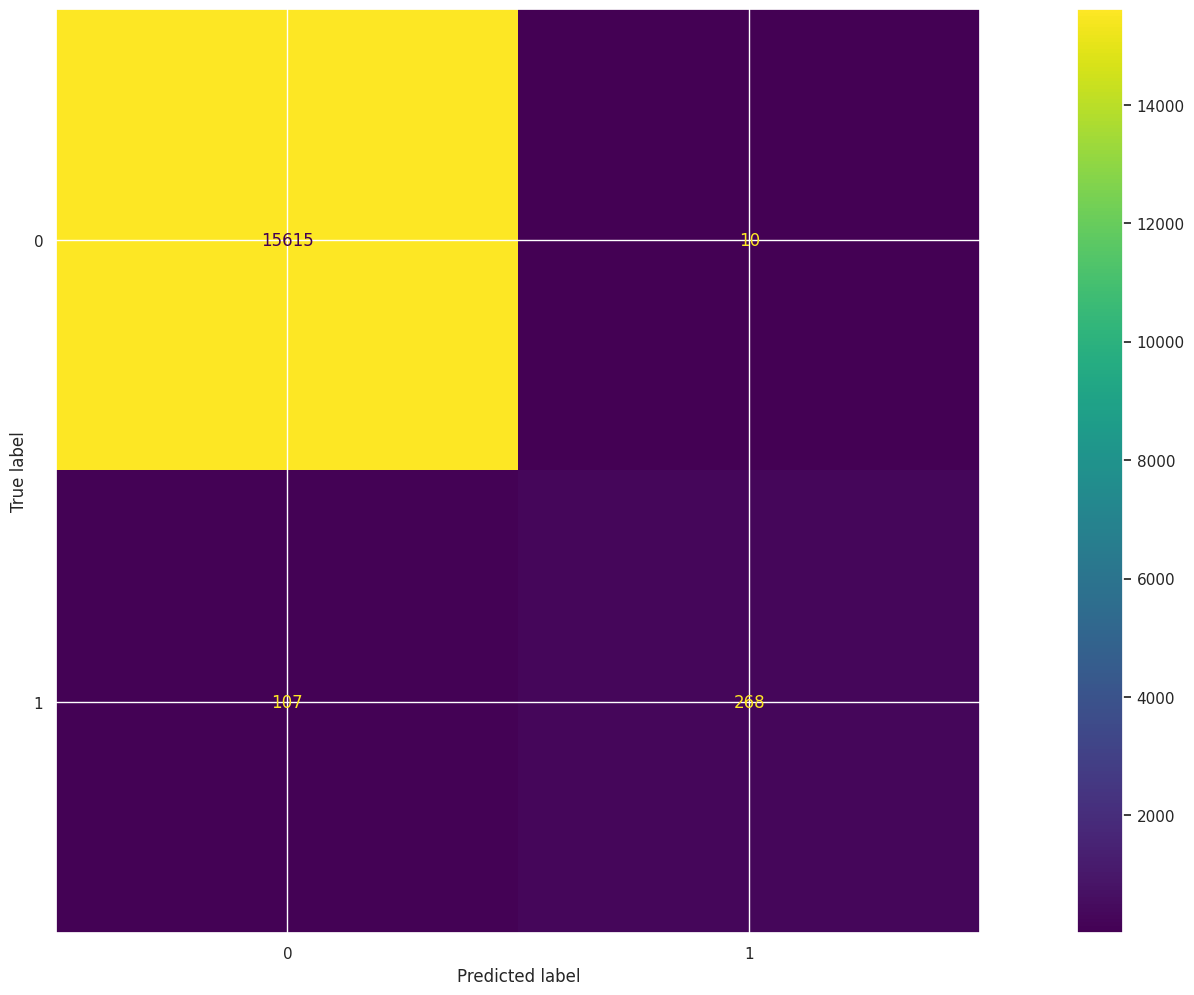

In [279]:
cm = confusion_matrix(y_test, yhat_xgboost, labels=xgboost.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=xgboost.classes_)

disp.plot()

# 10. Business Results

--> Modelo XGBoost com Padronização dos Dados
    
Da frota de 16 mil caminhões:
* 15615 nao apresentam problemas no sistema de ar e nosso modelo acertou -> logo o custo de cada caminhão na manutenção é de 10 dol por caminhao, valor total: 156.150 dol
* 107 caminhoes apresentavam problemas no sistema de ar mas nosso modelo errou > Logo o custo é de 500 dolares por caminhao, valor total: 53.500 dol
* 10 nao apresentam problemas no sistema de ar e nosso modelo errou -> logo o custo de cada caminhao na manutencao é de 10* por caminhao: 100 dol
* 268 apresentaram problemas no sistema de ar e o nosso modelo acertou -> logo o custo da manutencao preventiva é de 25 dolares por caminhao: 6.700 dolares

In [282]:
print('Custo Total de manutenções para essa solução utilizando modelo Baseline para o ano corrente é de $216.450,00') 
print('Custo com manutenção para sistema de ar: $53.500,00')
print('Valor Gasto constatado pelo time de negócios para ano corrente: $37.000,00')

Custo Total de manutenções para essa solução utilizando modelo Baseline para o ano corrente é de $216.450,00
Custo com manutenção para sistema de ar: $53.500,00
Valor Gasto constatado pelo time de negócios para ano corrente: $37.000,00


* R1. Portanto, para o nosso segundo ciclo desenvolvemos um modelo alternativo utilizando XGBoost e Padronizando os dados e já conseguimos cortar pela metade o custo se comparado ao baseline que haviámos criado no ciclo passado.